In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from numpy import linalg as LA
from scipy import linalg as LA
import os
import math


In [50]:
image = np.array([[615 , 1700],
                          [1132, 1640],
                          [1930, 1640],
                          [2418, 1706],
                          [1544, 2090],
                          [1544, 2555],
                          [1277, 1802],
                          [1792, 1806]])

world = np.array([[   0,   0, 168],
                          [   0,   0,  84],
                          [  84,   0,   0],
                          [ 168,   0,   0],
                          [   0,  84,   0],
                          [   0, 168,   0],
                          [   0,  28,  56],
                          [  56,  28,   0]])

In [51]:
world1 = np.hstack((np.zeros(6*8)[:,None],np.tile(np.arange(1,9),(6,1)).T.ravel()[:,None],-1*np.tile(np.arange(6,0,-1),(1,8)).T.ravel()[:,None]))
world2 = np.hstack((np.tile(np.arange(1,7),(1,8)).T.ravel()[:,None],np.tile(np.arange(1,9),(6,1)).T.ravel()[:,None],np.zeros(6*8)[:,None]))
calib_obj = cv2.imread("Camera_calibration_data/calib-object.jpg")
im_half1 = calib_obj[:,:calib_obj.shape[1]//2-50]
im_half2 = calib_obj[:,calib_obj.shape[1]//2:]
reta, corners1 = cv2.findChessboardCorners(im_half1,(6,8))
retb, corners2 = cv2.findChessboardCorners(im_half2,(6,8))
corners1 = corners1[:,0,:]
corners2 = corners2[:,0,:]
corners2[:,0] += calib_obj.shape[1]//2
image = np.vstack((corners1,corners2))
world = np.vstack((world1, world2))
# print (image)
# print (world)

# DLT

In [52]:
def DLT(world_point, image_point):
    trans = []
    for i in range(world_point.shape[0]):
        x = world_point[i,0]
        y = world_point[i,1]
        z = world_point[i,2]
        u = image_point[i,0]
        v = image_point[i,1]
        #print (trans)
        #frame the DLT equations as matrix transforms
        trans.append([x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u])
        trans.append([0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v])
    trans = np.array(trans)
    #do SVD to solve least squares minimization problem
    U,D,V = LA.svd(trans)
    #last column gives params
    L = V[-1:]
    #reshape the column vector to a 3*4 homography
    H = L.reshape(3,4)
    #print (H.shape)
    print ("Projection matrix:")
    print (H)
    return H

In [53]:
DLT(world, image)

Projection matrix:
[[-3.05125352e-02 -7.31516249e-03 -7.74423073e-02 -6.89821827e-01]
 [ 1.60745140e-02 -8.36504249e-02 -1.60366367e-02 -7.13898348e-01]
 [ 1.45950579e-05 -4.62905071e-06 -1.41473815e-05 -4.48443414e-04]]


array([[-3.05125352e-02, -7.31516249e-03, -7.74423073e-02,
        -6.89821827e-01],
       [ 1.60745140e-02, -8.36504249e-02, -1.60366367e-02,
        -7.13898348e-01],
       [ 1.45950579e-05, -4.62905071e-06, -1.41473815e-05,
        -4.48443414e-04]])

In [71]:
# np.insert(world, 3, 1, axis=1)

# Decompose Projection

In [55]:
def K_R_T_from_P(P):
    Q,W= np.linalg.qr(np.linalg.inv(P[:, 0:3]))
    t = np.dot(np.linalg.inv(P[:, 0:3]), -1 * P[:, 3])
    K = LA.inv(W)
    K = K/K[2,2]
    print ("Camera matrix:")
    print (K)
    print ("Rotation:")
    print (np.linalg.inv(Q))
    print ("Translation")
    print (t)
    return K, np.linalg.inv(Q), t
    

In [56]:
P = DLT(world, image)
K_R_T_from_P(P)

Projection matrix:
[[-3.05125352e-02 -7.31516249e-03 -7.74423073e-02 -6.89821827e-01]
 [ 1.60745140e-02 -8.36504249e-02 -1.60366367e-02 -7.13898348e-01]
 [ 1.45950579e-05 -4.62905071e-06 -1.41473815e-05 -4.48443414e-04]]
Camera matrix:
[[-3.68603521e+03 -1.71262474e+01  1.57420188e+03]
 [-0.00000000e+00 -3.67064394e+03  1.95288107e+03]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
Rotation:
[[-0.69532152  0.00416451 -0.71868675]
 [-0.16241063 -0.97502637  0.15148061]
 [-0.70010768  0.22205009  0.67863318]]
Translation
[ 15.54277708  -2.7150417  -14.77500386]


(array([[-3.68603521e+03, -1.71262474e+01,  1.57420188e+03],
        [-0.00000000e+00, -3.67064394e+03,  1.95288107e+03],
        [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]]),
 array([[-0.69532152,  0.00416451, -0.71868675],
        [-0.16241063, -0.97502637,  0.15148061],
        [-0.70010768,  0.22205009,  0.67863318]]),
 array([ 15.54277708,  -2.7150417 , -14.77500386]))

# Reprojection error

In [57]:
def error(P,world,image):
#     P = np.dot(K,np.hstack((R[:,0:2],t)))
    err = 0
    count = 0
#     image = np.insert(image, 2, 1, axis=1)
    for (x, y, z) in world:
        point = np.array([x, y, z, 1])
        proj = np.dot(P,point)
        print (proj.reshape(1,3))
        proj = proj[0:2] / proj[2]
        error = LA.norm(proj - image[count], ord = 2)
        err +=error
        count +=1
    return err/world.shape[0]

In [58]:
error(P,world, image)

[[-2.32483146e-01 -7.01328952e-01 -3.68188176e-04]]
[[-3.09925453e-01 -7.17365589e-01 -3.82335557e-04]]
[[-3.87367761e-01 -7.33402226e-01 -3.96482939e-04]]
[[-4.64810068e-01 -7.49438862e-01 -4.10630320e-04]]
[[-5.42252375e-01 -7.65475499e-01 -4.24777702e-04]]
[[-6.19694682e-01 -7.81512136e-01 -4.38925083e-04]]
[[-2.39798308e-01 -7.84979377e-01 -3.72817226e-04]]
[[-3.17240616e-01 -8.01016014e-01 -3.86964608e-04]]
[[-3.94682923e-01 -8.17052651e-01 -4.01111990e-04]]
[[-4.72125230e-01 -8.33089287e-01 -4.15259371e-04]]
[[-5.49567538e-01 -8.49125924e-01 -4.29406753e-04]]
[[-6.27009845e-01 -8.65162561e-01 -4.43554134e-04]]
[[-2.47113471e-01 -8.68629802e-01 -3.77446277e-04]]
[[-3.24555778e-01 -8.84666439e-01 -3.91593659e-04]]
[[-4.01998086e-01 -9.00703076e-01 -4.05741040e-04]]
[[-4.79440393e-01 -9.16739712e-01 -4.19888422e-04]]
[[-5.56882700e-01 -9.32776349e-01 -4.34035803e-04]]
[[-6.34325007e-01 -9.48812986e-01 -4.48183185e-04]]
[[-2.54428633e-01 -9.52280227e-01 -3.82075328e-04]]
[[-3.3187094

2.29116721760245

# Ransac 

In [59]:
def ransac(world, image, num_iter = 50):
#     num_iter = 300
    P_init = []
    minimum = 9999999
    for i in range(num_iter):
        ind = np.random.choice(world.shape[0],8,replace = False)
#         ind = np.random.permutation(world.shape[0])
        P = DLT(world[ind],image[ind])
        err = error(P, world[ind], image[ind])
        if err < minimum:
            minimum = err
            P_init = P
            print (err)
    print ("Projection for minimum error:",P_init)
    return P_init
            
    

In [60]:
P = ransac(world, image)
K, R, t = K_R_T_from_P(P)


Projection matrix:
[[-3.00315983e-02 -6.84893768e-03 -7.72531563e-02 -6.88287803e-01]
 [ 1.59130949e-02 -8.19495529e-02 -1.68106580e-02 -7.15605540e-01]
 [ 1.46397755e-05 -4.13846171e-06 -1.44803066e-05 -4.48517848e-04]]
[[-2.52164616e-01 -9.42539804e-01 -3.78189855e-04]]
[[-8.65841545e-01 -9.63838278e-01 -3.91872817e-04]]
[[-6.31581460e-01 -9.44643541e-01 -4.46452926e-04]]
[[-2.59013554e-01 -1.02448936e+00 -3.82328316e-04]]
[[-3.15719897e-01 -7.95451357e-01 -3.84393238e-04]]
[[-4.63377272e-01 -7.47123120e-01 -4.09215389e-04]]
[[-8.26325162e-01 -1.24151313e+00 -4.33567753e-04]]
[[-6.24732522e-01 -8.62693988e-01 -4.42314464e-04]]
0.9935741820140909
Projection matrix:
[[ 3.03256621e-02  6.61169727e-03  7.61137828e-02  6.90343987e-01]
 [-1.61846283e-02  8.26619690e-02  1.35649719e-02  7.13715180e-01]
 [-1.45534233e-05  4.31656668e-06  1.27270328e-05  4.47678760e-04]]
[[7.94544368e-01 8.30485233e-01 4.12651623e-04]]
[[5.64563211e-01 1.01723311e+00 4.39490961e-04]]
[[8.27602855e-01 1.243795

# Radial Distortion

In [57]:
def radial(data, world, image, K_init):
    # convert to grayscale
#     gray = cv2.cvtColor(data,cv2.COLOR_BGR2GRAY)
    K_init = np.array(np.float32(K_init))
#     K_init = K_init @ np.diag(-1*np.ones(3))
    K_init[0,1] = 0
    
#     print (K_init)
#     print (K_init.dtype)
    world = np.float32((np.array(world)))
    image = np.float32((np.array(image)))
#     image = image[:,:2]
    K_init = cv2.UMat(K_init)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([world[:,:3].astype('float32')],[image[:,:2].astype('float32')], (data.shape[1],data.shape[0]),K_init , None, None, flags = (cv2.CALIB_USE_INTRINSIC_GUESS))
    h,  w = data.shape[:2]
    newK, roi = cv2.getOptimalNewCameraMatrix(K_init, dist, (w, h), 1, (w, h))
    data_undistort = cv2.undistort(data, K_init,dist,None,mtx)
    data_undistort = data_undistort.get()
#     x, y, w, h = roi
#     data_undistort = data_undistort[y:y+h, x:x+w]
    return data_undistort    

Projection matrix:
[[-3.02942947e-03 -3.83034335e-04  5.60470221e-03 -9.99731103e-01]
 [-7.27705087e-04 -6.07234265e-03 -6.90345821e-04 -2.14026368e-02]
 [ 1.19342021e-06 -3.93175284e-07  1.12076971e-06 -1.01597810e-03]]
Camera matrix:
[[ 3.65816331e+03 -7.67017666e+00  9.93592299e+02]
 [ 0.00000000e+00  3.64587750e+03  2.62902305e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation:
[[-6.84711028e-01 -8.01363343e-04  7.28814219e-01]
 [-1.69654728e-01 -9.72353166e-01 -1.60457450e-01]
 [ 7.08793399e-01 -2.33513764e-01  6.65644981e-01]]
Translation
[ 435.62145442 -101.98428329  406.8640953 ]
[[[35 34 38]
  [35 34 38]
  [34 33 37]
  ...
  [27 26 30]
  [27 26 30]
  [27 26 30]]

 [[36 35 39]
  [35 34 38]
  [34 33 37]
  ...
  [27 26 30]
  [27 26 30]
  [27 26 30]]

 [[35 34 38]
  [35 33 39]
  [34 32 38]
  ...
  [27 26 30]
  [27 26 30]
  [27 26 30]]

 ...

 [[37 36 40]
  [37 36 40]
  [37 36 40]
  ...
  [30 28 34]
  [29 27 33]
  [30 29 33]]

 [[37 36 40]
  [38 37 41]
  [37 36 40]
 

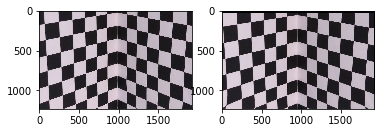

In [58]:
data = cv2.imread("Camera_calibration_data/Fig1.png")
# world = np.array([[126,14,0,1],
# [  0 , 42,  98,   1],
# [ 42 , 42,   0 ,  1],
# [154 , 42,   0,   1],
# [  0 , 70 , 70 ,  1],
# [ 70 , 70 ,  0 ,  1],
# [  0 , 98 , 42 ,  1],
# [ 98 , 98 ,  0 ,  1],
# [  0 ,126, 126,   1],
# [  0 ,126,  14 ,  1],
# [126 ,126,   0,   1],
# [  0 ,238, 182,   1],
# [  0 ,238,  70,   1],
# [ 14 ,238,   0,   1],
# [126 ,238 ,  0,   1],
# [  0, 210, 154,   1],
# [  0, 210 , 42 ,  1],
# [ 98, 210,   0,   1],
# [  0 ,154, 154 ,  1],
# [  0, 154 , 42,   1],
# [ 42, 154,   0,   1],
# [154, 154,   0,   1]])
# image = np.array([[1595 ,  37],
# [ 504 , 196],
# [1169 , 141],
# [1758 , 262],
# [ 655 , 336],
# [1290 , 344],
# [ 796 , 475],
# [1428 , 563],
# [ 366 , 767],
# [ 924 , 599],
# [1567 , 778],
# [  71, 1590],
# [ 659, 1343],
# [1039, 1222],
# [1550, 1486],
# [ 220, 1365],
# [ 792, 1118],
# [1413 ,1228],
# [ 198 ,1002],
# [ 797 , 799],
# [1154 , 810],
# [1715, 1008]])
image = np.array([[ 985,   21],
                          [1105,   43],
                          [1368,   91],
                          [1852,  176],
                          [ 985,  187],
                          [ 982,  506],
                          [ 984,  964],
                          [ 853,   41],
                          [ 574,   87],
                          [  70,  165],
                          [ 587,  616],
                          [ 129, 1121],
                          [ 594,  950],
                          [ 583,  444],
                          [1220,  747],
                          [1348,  961],
                          [1658,  532],
                          [1354,  624],
                          [1100,  702],
                          [1105,  214]])
    
    
world = np.array([[   0,   0,   0],
                          [   1,   0,   0],
                          [   3,   0,   0],
                          [   6,   0,   0],
                          [   0,   1,   0],
                          [   0,   3,   0],
                          [   0,   6,   0],
                          [   0,   0,   1],
                          [   0,   0,   3],
                          [   0,   0,   6],
                          [   0,   3,   3],
                          [   0,   5,   6],
                          [   0,   5,   3],
                          [   0,   2,   3],
                          [   2,   4,   0],
                          [   3,   5,   0],
                          [   5,   2,   0],
                          [   3,   3,   0],
                          [   1,   4,   0],
                          [   1,   1,   0]])
world = world * 28
P = DLT(world, image)
K, R, t = K_R_T_from_P(P)
K.astype('float32')
# print (world.shape)

print(data)
fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(data)
# print (K.shape)
plt.subplot(1,2,2)
plt.imshow(radial(data, world, image, K))
plt.show()

# Zhang's Algorithm

In [61]:
def points(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\
    print (image.shape)
    world_point = np.hstack((np.tile(np.arange(1,8),(1,7)).T.flatten()[:,None],np.tile(np.arange(7,0,-1),(7,1)).T.flatten()[:,None],np.zeros(7*7)[:,None])).astype(np.float32)
    ret, corners = cv2.findChessboardCorners(image,(7,7))
    corners = corners.reshape(-1,2)
    if ret:
        return world_point, corners, image.shape[:2]
    else:
        return None, None, None
def points1(image):
    
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\
    world_point = np.hstack((np.tile(np.arange(1,9),(1,6)).T.flatten()[:,None],np.tile(np.arange(6,0,-1),(8,1)).T.flatten()[:,None],np.zeros(8*6)[:,None])).astype(np.float32)
    ret, corners = cv2.findChessboardCorners(image,(8,6))
    corners = corners.reshape(-1,2)
    if ret:
        return world_point, corners, image.shape[:2]
    else:
        return None, None, None

In [62]:
def zhang(image_list):
    world_point = []
    image_point = []
    count = 0
    for i in image_list:
        count += 1
        w_pt, im_pt, shape = points (i)
        world_point.append(w_pt)
        image_point.append(im_pt)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world_point, image_point, (i.shape[1],i.shape[0]), None, None)
    return ret, mtx, dist, rvecs, tvecs
def zhang1(image_list):
    world_point = []
    image_point = []
    count = 0
    for i in image_list:
        count += 1
        w_pt, im_pt, shape = points1(i)
        world_point.append(w_pt)
        image_point.append(im_pt)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world_point, image_point, (i.shape[1],i.shape[0]), None, None)
    return ret, mtx, dist, rvecs, tvecs
    
        
        
        

In [74]:
im = []
start = 5456
for i in np.arange(15):
    im.append(cv2.imread("Camera_calibration_data/" + 'IMG_' + str(start+i) + '.JPG'))

In [75]:
ret, mtx, dist, rvecs, tvecs = zhang1(im)
print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
print('Rotation Vectors for the images are:')
print(rvecs)
print('Translation Vectors for the images are:')
print(tvecs)

Reprojection Error: 2.481084983660572
Camera Calibration Matrix:
[[1.36634762e+04 0.00000000e+00 3.33653229e+03]
 [0.00000000e+00 1.36813824e+04 1.49659839e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:
[[ 9.52117076e-02  1.01093672e+01 -1.52799117e-02  2.87211432e-02
  -1.60591737e+02]]
Rotation Vectors for the images are:
[array([[-3.15370654],
       [ 0.0048923 ],
       [-0.08184612]]), array([[ 3.11380398],
       [ 0.05524553],
       [-0.35422692]]), array([[-3.08212366],
       [ 0.05586291],
       [-0.65088103]]), array([[-2.97498081],
       [ 0.11925039],
       [-0.95085296]]), array([[-3.09829883],
       [-0.1022205 ],
       [ 0.48077981]]), array([[ 2.79880451],
       [-0.02471114],
       [ 0.31521866]]), array([[ 2.89571909],
       [-0.00561004],
       [ 0.56622671]]), array([[-2.8601593 ],
       [-0.03584616],
       [-0.46779797]]), array([[-2.8271998 ],
       [-0.10060625],
       [ 0.09460227]]), array([[-2.68280355],
       [ 

# Wireframe

Reprojection Error: 2.4810849836605895
Camera Calibration Matrix:
[[1.36634762e+04 0.00000000e+00 3.33653229e+03]
 [0.00000000e+00 1.36813824e+04 1.49659839e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:
[[ 9.52117076e-02  1.01093672e+01 -1.52799117e-02  2.87211432e-02
  -1.60591737e+02]]
Rotation Vectors for the images are:
[array([[-3.15370654],
       [ 0.0048923 ],
       [-0.08184612]]), array([[ 3.11380398],
       [ 0.05524553],
       [-0.35422692]]), array([[-3.08212366],
       [ 0.05586291],
       [-0.65088103]]), array([[-2.97498081],
       [ 0.11925039],
       [-0.95085296]]), array([[-3.09829883],
       [-0.1022205 ],
       [ 0.48077981]]), array([[ 2.79880451],
       [-0.02471114],
       [ 0.31521866]]), array([[ 2.89571909],
       [-0.00561004],
       [ 0.56622671]]), array([[-2.8601593 ],
       [-0.03584616],
       [-0.46779797]]), array([[-2.8271998 ],
       [-0.10060625],
       [ 0.09460227]]), array([[-2.68280355],
       [

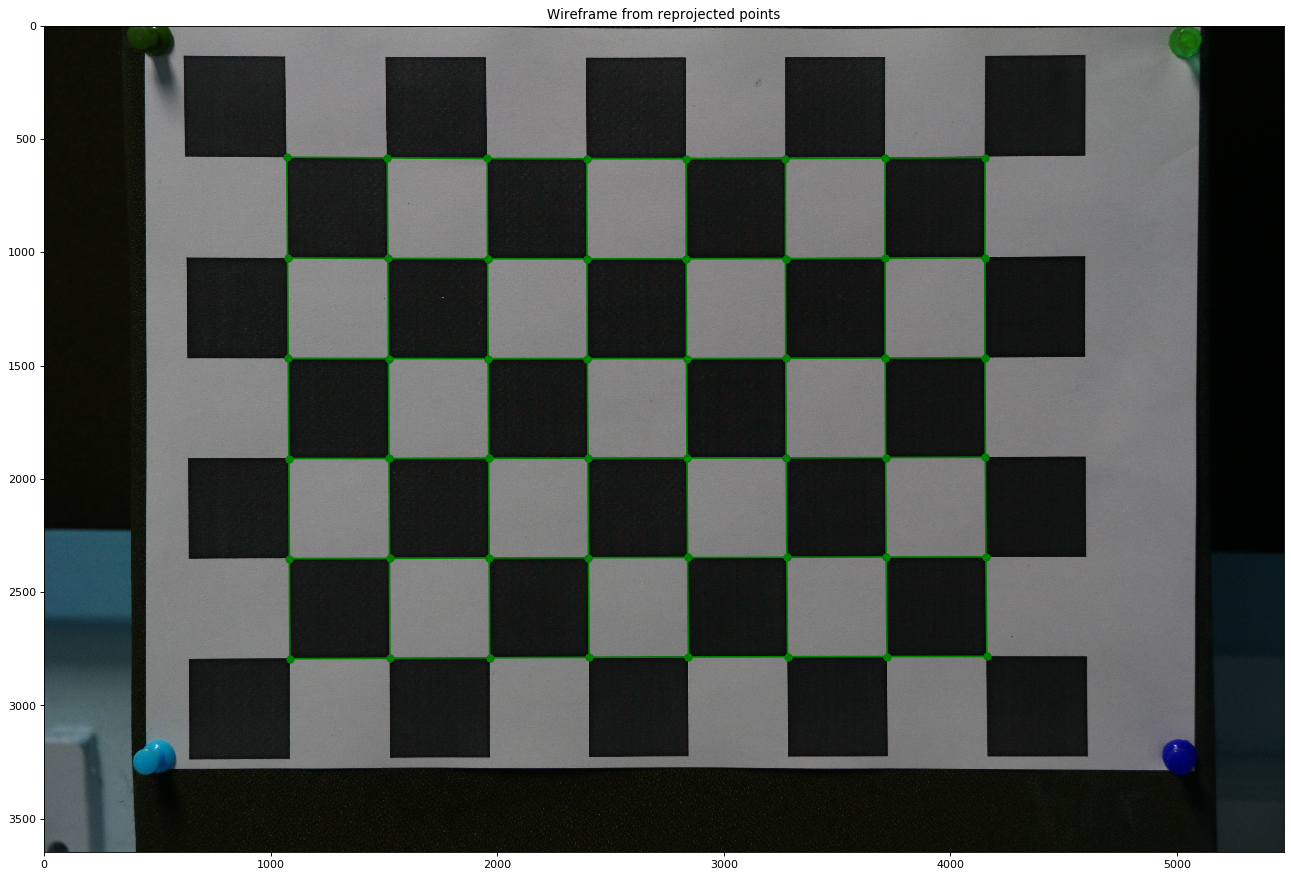

In [76]:
for i in np.arange(15):
    im.append(cv2.imread("Camera_calibration_data/" + 'IMG_' + str(start+i) + '.JPG'))
ret, mtx, dist, rvecs, tvecs = zhang1(im)
print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
print('Rotation Vectors for the images are:')
print(rvecs)
print('Translation Vectors for the images are:')
print(tvecs)
world_point = np.hstack((np.tile(np.arange(1,9),(1,6)).T.flatten()[:,None],np.tile(np.arange(6,0,-1),(8,1)).T.flatten()[:,None],np.zeros(8*6)[:,None])).astype(np.float32)
  

r = rvecs[0]
#####



# R = (eulerAnglesToRotationMatrix(r))

# world_points_1 = np.insert(world_point,3,1,axis=1)

 

# temp1 = np.zeros((3,4))

# temp1[0:3,0:3] = R[0:3,0:3]

# temp1[:,3] = tvecs[0][:,0]

# P = np.matmul(mtx,temp1)

# P = P/P[2,3]

 

# projected_points = []

# for i in range(48):

#     projection = np.matmul(P,np.transpose(world_points_1[i,:]))

#     projection = projection/projection[2]

#     projected_points.append(projection[0:2])
projected_points,_ = cv2.projectPoints(world_point,rvecs[0],tvecs[0],mtx,dist)

projected_points = projected_points[:,0,:]

### Wireframe

idx = [7,15,23,31,39,47]

q = 0

p = 0

fig = plt.figure(figsize=(20,20),dpi=80)

for i in range(projected_points.shape[0]):

    if (i == idx[q]):

        q = q + 1

        continue

    plt.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'go-')

for i in range(8):

    i1 = i

    j =  i + 8

    while(j < 48):

        plt.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'go-')

        i1 = j

        j = j + 8

plt.imshow(cv2.imread("Camera_calibration_data/"+'IMG_'+str(5456)+'.JPG'))

plt.title('Wireframe from reprojected points')

plt.show()


Origin is:
[6.15791220e+02 3.25469435e+03 1.00000000e+00]


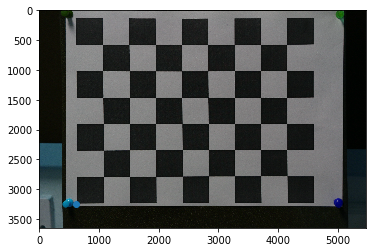

In [84]:
# Finding origin

rotation_mat = np.zeros(shape=(3, 3))

R = cv2.Rodrigues(rvecs[0], rotation_mat)[0]

world_points_1 = np.insert(world_point,3,1,axis=1)

 

temp1 = np.zeros((3,4))

temp1[0:3,0:3] = R[0:3,0:3]

temp1[:,3] = tvecs[0][:,0]

P = np.matmul(mtx,temp1)

P = P/P[2,3]

w_origin_im = P.dot(np.array([0,0,0,1])) #orgin assumed is bottom left corner
print ("Origin is:")
print(w_origin_im)

plt.scatter(w_origin_im[0],w_origin_im[1])

plt.imshow(cv2.imread("Camera_calibration_data/"+'IMG_'+str(5456)+'.JPG'))


# Hands on - Zhang's

In [68]:
# Zhang's
im = []
for i in np.arange(8):
    im.append(cv2.imread("Checkerboard/" +  str(i+1) + '.jpg'))
ret, mtx, dist, rvecs, tvecs = zhang(im)
print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
print('Rotation Vectors for the images are:')
print(rvecs)
print('Translation Vectors for the images are:')
print(tvecs)



(960, 1280, 3)
(960, 1280, 3)
(960, 1280, 3)
(960, 1280, 3)
(960, 1280, 3)
(960, 1280, 3)
(960, 1280, 3)
(960, 1280, 3)
Reprojection Error: 0.9814698747743387
Camera Calibration Matrix:
[[3.71013199e+03 0.00000000e+00 5.88238742e+02]
 [0.00000000e+00 3.81360976e+03 4.90492693e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:
[[ 6.05060296e+00 -3.88405337e+02  1.15882395e-02 -6.15665408e-02
  -2.92505410e+03]]
Rotation Vectors for the images are:
[array([[ 2.91646146],
       [-0.00313974],
       [-0.00307743]]), array([[2.90959813e+00],
       [5.06329843e-04],
       [1.10290757e-02]]), array([[ 2.92133233e+00],
       [ 2.27531339e-03],
       [-1.48794103e-02]]), array([[ 2.92513377e+00],
       [-2.36884854e-03],
       [-1.31450507e-02]]), array([[ 2.91328597e+00],
       [-9.31006021e-05],
       [-1.40774448e-02]]), array([[ 2.91535744e+00],
       [-6.70340358e-03],
       [ 2.07797321e-03]]), array([[ 2.91799478],
       [-0.00900123],
       [ 0.01

# Hands on-DLT

Projection matrix:
[[ 2.25682647e-02  2.91589842e-03 -3.52130305e-03  4.69785434e-01]
 [-1.69412184e-03  9.86979233e-03 -2.43346616e-02  8.82087775e-01]
 [ 1.75323929e-06  9.84943746e-06 -2.79771375e-06  3.41674820e-04]]
Camera matrix:
[[ 2.08660660e+03  1.87783097e+02  7.24097285e+02]
 [-0.00000000e+00 -2.03818640e+03  1.50421097e+03]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
Rotation:
[[-0.96419184  0.21552659  0.15453928]
 [-0.20457141 -0.23359326 -0.95057074]
 [-0.16877394 -0.94814686  0.26931929]]
Translation
[-13.39489596 -24.57557139  27.21322311]


(array([[ 2.08660660e+03,  1.87783097e+02,  7.24097285e+02],
        [-0.00000000e+00, -2.03818640e+03,  1.50421097e+03],
        [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]]),
 array([[-0.96419184,  0.21552659,  0.15453928],
        [-0.20457141, -0.23359326, -0.95057074],
        [-0.16877394, -0.94814686,  0.26931929]]),
 array([-13.39489596, -24.57557139,  27.21322311]))

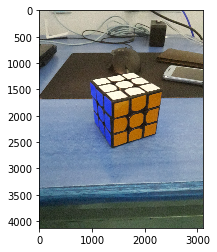

In [69]:
image = cv2.imread("rubiks.jpg")
plt.imshow(image)
world = np.array([[   0,   0,   0],
                          [   5,   0,   0],
                          [  15,   0,   0],
                          [   0,   5,   0],
                          [   0,  15,   0],
                          [   0,   0,   5],
                          [   0,   0,  15],
                          [  15,  0,   15]])
image = np.array([[1374, 2577], [1665, 2490], [2198, 2330], [1240, 2382], [1049, 2105], [1374, 2330], [1396, 1723], [2315, 1507]])
P = DLT(world, image)
K_R_T_from_P(P)

Projection matrix:
[[-2.34386216e-02 -1.05923630e-03  3.42023135e-03 -4.69532048e-01]
 [ 1.04424718e-03 -6.14725843e-03  2.43118990e-02 -8.82239992e-01]
 [-2.17371749e-06 -8.34909610e-06  2.60700459e-06 -3.40255856e-04]]
Camera matrix:
[[ 2.48642612e+03  1.52419255e+02  8.45870668e+02]
 [ 0.00000000e+00 -2.41645643e+03  1.38417914e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation:
[[-0.95246883  0.28310481  0.11249353]
 [-0.18610107 -0.24837831 -0.95061801]
 [-0.24118358 -0.92636919  0.28925871]]
Translation
[-14.41729278 -27.65938114  29.91398757]


(array([[ 2.48642612e+03,  1.52419255e+02,  8.45870668e+02],
        [ 0.00000000e+00, -2.41645643e+03,  1.38417914e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-0.95246883,  0.28310481,  0.11249353],
        [-0.18610107, -0.24837831, -0.95061801],
        [-0.24118358, -0.92636919,  0.28925871]]),
 array([-14.41729278, -27.65938114,  29.91398757]))

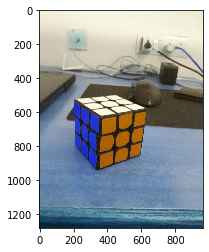

In [70]:
# Varying focus for DLT
image = cv2.imread("rubiks1.jpg")
plt.imshow(image)
world = np.array([[   0,   0,   0],
                          [   5,   0,   0],
                          [  15,   0,   0],
                          [   0,   5,   0],
                          [   0,  15,   0],
                          [   0,   0,   5],
                          [   0,   0,  15],
                          [  15,  0,   15]])

image = np.array([[1387, 2590], [1673, 2494], [2202, 2326], [1235, 2395], [1045, 2092], [1378, 2326], [1391, 1719], [2306, 1503]])

P = DLT(world, image)
K_R_T_from_P(P)


